In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import contractions
import re
import string

import pkg_resources
from symspellpy import SymSpell, Verbosity
from unidecode import unidecode

from bs4 import BeautifulSoup
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

import requests
import os 
import pickle

In [70]:
df = pd.read_csv("FDM_job_descriptions.csv")

In [71]:
df['job_text'][3]

'Cloud & Data Engineering Graduate Program    Is your brain your favourite feature?\nHow does building a career in cloud and data sound? \nReady to share your uncanny reasoning abilities with the world?  Learn how to manage companies’ most important digital assets Receive cutting edge, hybrid training in a highly sought after industry  Company culture committed to diversity, inclusion & fun  About the role Cloud & Data Engineering involves helping organisations understand their data and facilitate growth. Using advanced tools and frameworks you’ve learned and developed in FDM’s intensive training, you’ll work both individually and in groups, conducting data analysis and drawing insights from datasets.  At FDM’s Academy, depending on industry demand, you may have the chance to learn languages such as Azure, SQL, HiveQL, Python and Spark along with the practical Excel skills used by every successful Cloud & Data Engineer. Dive headfirst into inspiring projects where you will work collabo

In [72]:
# Create the 'pickles/' directory if it doesn't exist
os.makedirs('pickles', exist_ok=True)

### Text Cleaning 

Function to deal with abbreviations.

In [73]:
def normalize_abbreviations(text):
    matches = re.finditer(r"([A-Z]\.)+", text)
    matched_abbr = [match.group() for match in matches]
    for abbr in matched_abbr:
        text = re.sub(abbr,abbr.replace(".",""), text)
    return text

In [74]:
df_norm = df.copy()
df_norm['job_text'] = df['job_text'].apply(normalize_abbreviations)

Function to handle punctuations.

In [75]:
punct_to_keep = ["&"]
punct_to_remove = "".join(punct for punct in string.punctuation if punct not in punct_to_keep)
def handle_punctuations(text):
    text = re.sub('[%s]' % re.escape(punct_to_remove), " ",text)
    for punct in punct_to_keep:
        text = re.sub(f"{punct}", f" {punct} ",text)
    return text

def replace_ampersand(text):
    return text.replace('&', 'and')

In [76]:
df_punc = df_norm.copy()
df_punc['job_text'] = df_norm['job_text'].apply(handle_punctuations)
df_punc['job_text'] = df_punc['job_text'].apply(replace_ampersand)

Function to handle numbers.

In [77]:
def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    text = re.sub('[0-9]{1}', '#', text)
    return text

In [78]:
df_num = df_punc.copy()
df_num['job_text'] = df_punc['job_text'].apply(clean_numbers)

Function to handle html tags, contractions, emails, urls, extra spaces.

In [79]:
# For HTML removal with regex
HTML_ENTITIES = ["</\w+>", "<\w+>", "&nbsp;", "&lt;", "&gt;", "&amp;", "&quot;", 
                 "&apos;", "&cent;", "&pound;", "&yen;", "&euro;", "&copy;", "&reg;",]

# For Stopwords
stop_words = set(stopwords.words('english'))

# For Lemmatization
lemmatizer = WordNetLemmatizer()

# For symspellpy
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# For Britishize
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
american_to_british_dict = requests.get(url).json()

# For Americanize
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_dict = requests.get(url).json()

Function to handle html, contractions, lowercase, emails/url, accented words, unicode characters, digits and words with digits, special characters, extra spaces

In [80]:
def text_preprocessing(text):
    text = text.lower() # Lower
    for entity in HTML_ENTITIES: # Remove HTML
        text = re.sub(f"{entity}", " ", text)
    text = contractions.fix(text) # Expand contractions
    text = re.sub(re.compile(r'(https?://)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)'), "", text) # Remove url
    text = re.sub(re.compile(r'/^([a-z0-9_\.-]+)@([\da-z\.-]+)\.([a-z\.]{2,63})$/'), "", text) # Remove email
    text = unidecode(text) # Handle accented words
    text = text.encode("ascii", "ignore").decode() # Remove Unicode characters
    text = re.sub(re.compile("\w*\d+\w*"), "",text) # Remove digits and words with digits
    text = re.sub(r'[\\%"\'$()\'#]|["""]|\$', '', text) #Remove special characters
    text = re.sub(' +', ' ', text).strip()  # Remove extra space
    # text = " ".join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatization
    # text = " ".join([sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term for word in text.split()]) # Spelling correction
    # text = " ".join([sym_spell.lookup_compound(word, max_edit_distance=2)[0].term for word in text.split()]) # Compound word correction
    # text = " ".join([word for word in str(text).split() if word not in stop_words]) # Final stopwords removal
    text = " ".join([american_to_british_dict[word] if word in american_to_british_dict else word for word in text.split()]) # Britishize
    text = " ".join([british_to_american_dict[word] if word in british_to_american_dict else word for word in text.split()]) #Americanize
    return text

In [81]:
df_text = df_num.copy()
df_text['job_text'] = df_num['job_text'].apply(text_preprocessing)

Function to remove stopwords

In [82]:
def remove_stopwords(text):
    text = " ".join([word for word in str(text).split() if word not in stop_words])
    return text   

In [83]:
df_text_rs = df_text.copy()
df_text_rs['job_text'] = df_text['job_text'].apply(remove_stopwords)

In [84]:
df_text_rs['job_text'][3]

'cloud data engineering graduate program brain favorite feature building career cloud data sound ready share uncanny reasoning abilities world learn manage companies important digital assets receive cutting edge hybrid training highly sought industry company culture committed diversity inclusion fun role cloud data engineering involves helping organizations understand data facilitate growth using advanced tools frameworks learned developed fdms intensive training work individually groups conducting data analysis drawing insights datasets fdms academy depending industry demand may chance learn languages azure sql hiveql python spark along practical excel skills used every successful cloud data engineer dive headfirst inspiring projects work collaboratively within agile team constantly challenged apply develop new skillset performing well boost chances put forward work cutting edge client assignments big brand partners across various industries educated university degree level bachelor h

### Exploratory Data Analysis 

In [85]:
def tokenize_text(text):
    words = nltk.word_tokenize(text)    
    return words

def calculate_word_frequencies(words):
    word_freq = Counter(words)
    
    return word_freq

def generate_ngrams(words, n):
    ngrams_list = list(nltk.ngrams(words, n))
    
    return ngrams_list

In [86]:
df_text_EDA = df_text_rs.copy()
df_text_EDA['job_text'] = df_text_EDA['job_text'].apply(tokenize_text)
df_text_EDA['word_freq'] = df_text_EDA['job_text'].apply(calculate_word_frequencies)
df_text_EDA['bigrams'] = df_text_EDA['job_text'].apply(lambda x: generate_ngrams(x, 2))
df_text_EDA['trigrams'] = df_text_EDA['job_text'].apply(lambda x: generate_ngrams(x, 3))

In [87]:
df_text_EDA.head()

,job_title,job_text,word_freq,bigrams,trigrams
0,Data Engineering Graduate Program,"[data, engineering, graduate, program, love, f...","{'data': 5, 'engineering': 1, 'graduate': 3, '...","[(data, engineering), (engineering, graduate),...","[(data, engineering, graduate), (engineering, ..."
1,Business Graduate Program,"[business, graduate, program, consider, busine...","{'business': 7, 'graduate': 4, 'program': 3, '...","[(business, graduate), (graduate, program), (p...","[(business, graduate, program), (graduate, pro..."
2,Business Intelligence Graduate Program,"[business, intelligence, graduate, program, lo...","{'business': 2, 'intelligence': 1, 'graduate':...","[(business, intelligence), (intelligence, grad...","[(business, intelligence, graduate), (intellig..."
3,Cloud & Data Engineering Graduate Program,"[cloud, data, engineering, graduate, program, ...","{'cloud': 4, 'data': 6, 'engineering': 2, 'gra...","[(cloud, data), (data, engineering), (engineer...","[(cloud, data, engineering), (data, engineerin..."
4,2024 Graduate Program,"[graduate, program, creative, analytical, stra...","{'graduate': 4, 'program': 3, 'creative': 1, '...","[(graduate, program), (program, creative), (cr...","[(graduate, program, creative), (program, crea..."


In [88]:
from wordcloud import WordCloud

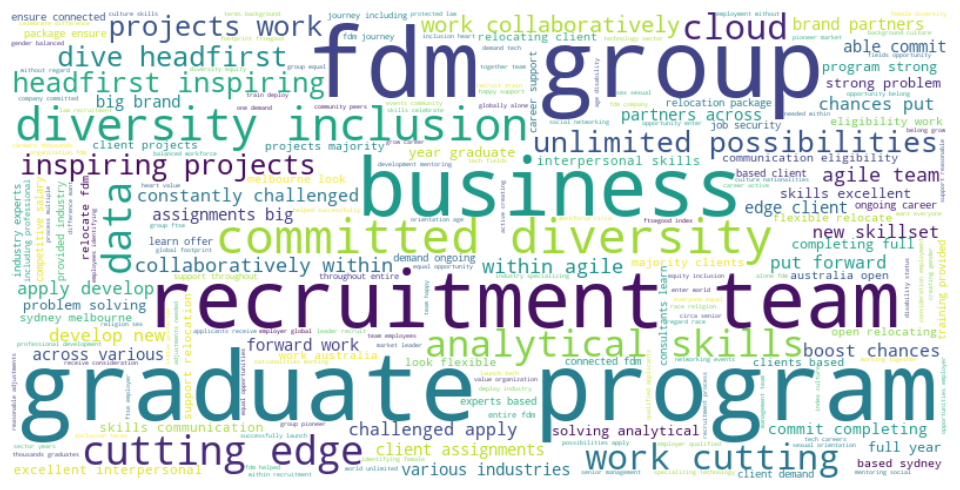

In [89]:
# Concatenate all the words from the 'words' column into a single string
all_words = ' '.join([' '.join(words) for words in df_text_EDA['job_text']])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

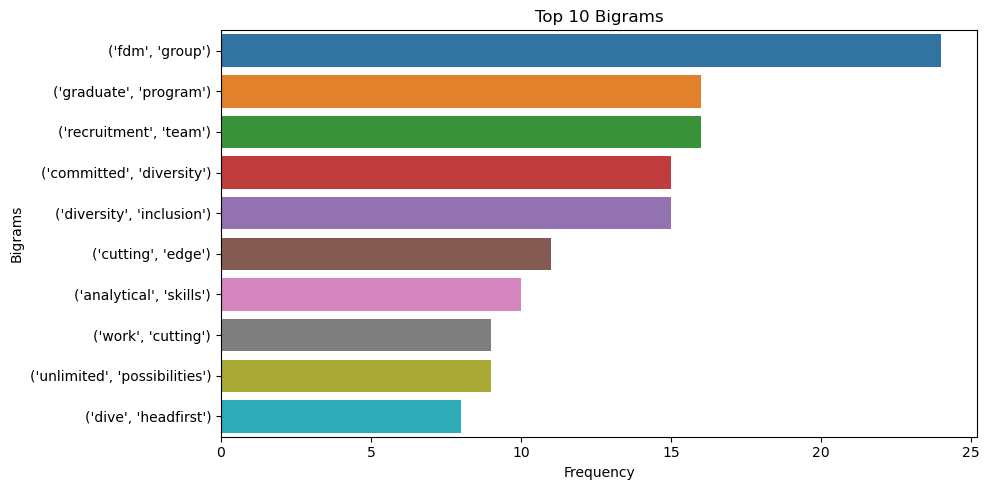

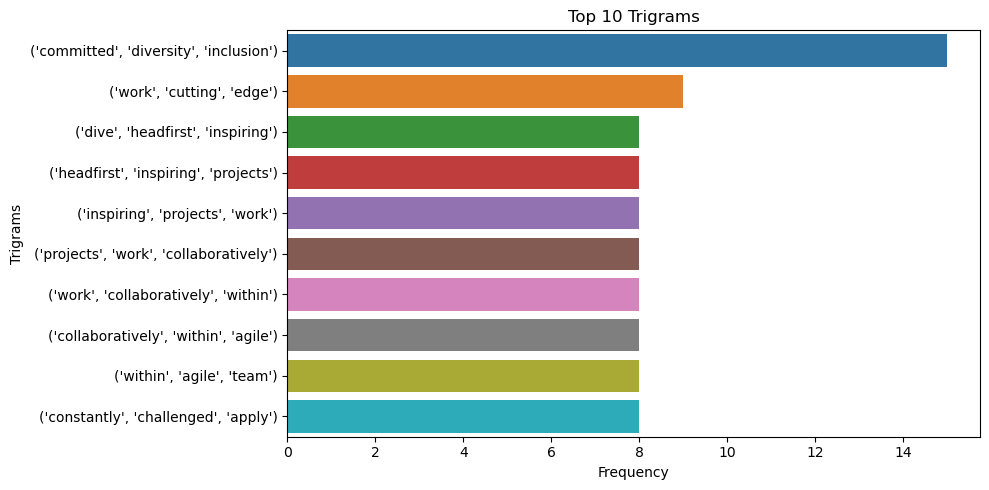

In [90]:
def plot_bigrams(df):
    all_bigrams = [bigram for bigrams in df['bigrams'] for bigram in bigrams]
    bigram_freq = Counter(all_bigrams)
    top_bigrams = bigram_freq.most_common(10)
    bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
    # Create a horizontal bar plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frequency', y='Bigram', data=bigram_df, orient='h')
    plt.xlabel('Frequency')
    plt.ylabel('Bigrams')
    plt.title('Top 10 Bigrams')
    plt.tight_layout()
    plt.show()

# Bar plot for trigrams
def plot_trigrams(df):
    all_trigrams = [trigram for trigrams in df['trigrams'] for trigram in trigrams]
    trigram_freq = Counter(all_trigrams)
    top_trigrams = trigram_freq.most_common(10)
    trigram_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])
    # Create a horizontal bar plot using Seaborn
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frequency', y='Trigram', data=trigram_df, orient='h')
    plt.xlabel('Frequency')
    plt.ylabel('Trigrams')
    plt.title('Top 10 Trigrams')
    plt.tight_layout()
    plt.show()

# Call the functions to plot bigrams and trigrams
plot_bigrams(df_text_EDA)
plot_trigrams(df_text_EDA)

### Keyword Extraction Techniques

#### Term Frequency - Inverse Document Frequency **(TF-IDF)**

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import process

In [92]:
# corpus is just a collection of documents
corpus = df_text_rs['job_text'].values

In [93]:
# init vectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,3))

In [94]:
# fit and transform text 
tfidf = vectorizer.fit_transform(corpus)
tfidf.shape
# get feature names
feature_names = vectorizer.get_feature_names_out()
# convert to array
tfidf.toarray()
# argsort sorts tfidf values in ascending order, take last 10 and then reverse the list to get in descending order
keyword_list = feature_names[np.argsort(tfidf.toarray()[6])[-10:][::-1]]
keyword_list

array(['fdm', 'grace', 'team', 'women', 'computer', 'apply', 'leading',
       'detective', 'digital detective', 'skills'], dtype=object)

In [95]:
# applying to entire corpus
extracted_keywords = []
for doc_tfidf in tfidf.toarray() :
    sorted_ids_top10 = np.argsort(doc_tfidf)[-10:][::-1]
    doc_keywords = feature_names[sorted_ids_top10].tolist()
    # Reducing duplication in keywords
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords)
    extracted_keywords.append(final_keywords)

In [96]:
df_text['keywords - TFIDF'] = extracted_keywords 
df_text['keywords - TFIDF'][3]

'cloud data engineering, fdms, team, work, industry, skills'

#### Rapid Automatic Keyword Extraction **(RAKE)**

In [97]:
from rake_nltk import Rake

In [98]:
# punctuations work as delimiters to split the text into phrases
punctuations = [punc for punc in string.punctuation]
punctuations.extend(['*.','--',').','),','?,'])

In [99]:
# RAKE function 
def extract_keywords_rake(text):
    r = Rake(
        stopwords= set(stopwords.words("english")),
        punctuations=punctuations,
        include_repeated_phrases=False,
        min_length=1,
        max_length=3)
    r.extract_keywords_from_text(text)
    doc_keywords = r.get_ranked_phrases()
    # Reducing duplication in keywords
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords[:10])
    return final_keywords

In [100]:
# since RAKE works with stopwords and punctuation - we need to find the data that keeps both
df_num_with_punc = df_norm.copy()
df_num_with_punc['job_text'] = df_norm['job_text'].apply(clean_numbers)
df_text_with_punc = df_num_with_punc.copy()
df_text_with_punc['job_text'] = df_num_with_punc['job_text'].apply(text_preprocessing)

In [101]:
df_text_with_punc['job_text'][3]

'cloud & data engineering graduate program is your brain your favorite feature? how does building a career in cloud and data sound? ready to share your uncanny reasoning abilities with the world? learn how to manage companies most important digital assets receive cutting edge, hybrid training in a highly sought after industry company culture committed to diversity, inclusion & fun about the role cloud & data engineering involves helping organizations understand their data and facilitate growth. using advanced tools and frameworks you have learned and developed in fdms intensive training, you will work both individually and in groups, conducting data analysis and drawing insights from datasets. at fdms academy, depending on industry demand, you may have the chance to learn languages such as azure, sql, hiveql, python and spark along with the practical excel skills used by every successful cloud & data engineer. dive headfirst into inspiring projects where you will work collaboratively w

In [102]:
# applying RAKE to the entire corpus
df_text['keywords - RAKE'] = df_text_with_punc['job_text'].apply(extract_keywords_rake)

In [103]:
df_text['keywords - RAKE'][3]

'using advanced tools, uncanny reasoning abilities, social networking events, nationalities working together, multiple start dates, including professional development, helped successfully launch, employment without regard, edge client assignments, entire fdm journey'

**TextRank**

The algorithm operates on the words and phrases in a text, treating each word or phrase as a node in a graph and connecting two nodes if they co-occur within a certain window size. The algorithm then uses the graph to rank the nodes, with the most important words and phrases having the highest ranks.

In [104]:
import spacy
import pytextrank

In [105]:
# load a spaCy model, depending on language, scale, etc.
nlp_textrank = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp_textrank.add_pipe("textrank")

In [106]:
# TextRank function
def extract_keywords_textrank(text):
    doc = nlp_textrank(text)
    doc_keywords = [keyword.text for keyword in doc._.phrases if len(keyword.text.split()) <= 3]
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords[:10])
    return final_keywords

In [107]:
# applying TextRank to the entire corpus
df_text['keywords - TextRank'] = df_text_with_punc['job_text'].apply(extract_keywords_textrank)

In [108]:
df_text['keywords - TextRank'][3]

'fdm fdm group, industry company culture, industry demand, other fdm consultants, equal opportunity, industry experts, various industries, client projects, ongoing career support, fdms intensive training'

#### KP-Miner 

KP-Miner is a statistics-based keyphrase extraction method (like TF-IDF). It composes of 3 steps: Candidate Keyphrase selection, Candidate keyphrases weight calculation, Final candidate phrase list refinement. Makes use of the `PKE - python keyphrase extraction` library. 

More details here: 
https://github.com/boudinfl/pke?tab=readme-ov-file

In [109]:
import pke 

In [110]:
# initialise KPMiner 
extractor = pke.unsupervised.KPMiner()

def extract_keywords_kpminer(text):
    extractor.load_document(input=text, language='en')
    extractor.candidate_selection(lasf=2) #east allowable seen frequency, defaults to 3 but this value only gave unigrams due to fewer words in the abstract and hence lasf value is set to 2
    extractor.candidate_weighting()
    doc_keywords = [keyword for keyword,score in extractor.get_n_best(n=20)] #N-best selection keyphrases contains the 20 highest scored candidates
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords[:10])
    return final_keywords

In [111]:
# applying TextRank to the entire corpus
df_text['keywords - KPMiner'] = df_text_with_punc['job_text'].apply(extract_keywords_kpminer)

In [112]:
df_text['keywords - KPMiner'][3]

'fdms, data engineering, graduate program, fdm group, cloud, career, relocating, skills, team, industry'

#### Yet Another Keyword Extractor **(YAKE)**

an unsupervised automatic keyword extraction method. Has the following steps: text pre-processing and candidate term identification -> feature extraction -> computing term score -> n-gram generation and computing candidate keyword score -> data deduplication and ranking.

More details here: https://github.com/LIAAD/yake

In [113]:
import yake

In [114]:
def extract_keywords_yake(text):
    y = yake.KeywordExtractor( 
        n=3, # maximum ngram size
        dedupLim=0.7, # deduplication threshold
        dedupFunc='seqm', # deduplication algorithm
        top=20, # No. of keywords
        features=None)
    doc_keywords = [keyword[0] for keyword in y.extract_keywords(text)]
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords[:10])
    return final_keywords

In [115]:
# applying YAKE to the entire corpus
df_text['keywords - YAKE'] = df_text_with_punc['job_text'].apply(extract_keywords_yake)

In [116]:
df_text['keywords - YAKE'][3]

'favorite feature, brain your favorite, fdm fdm group, data engineering graduate, engineering graduate program, team, cloud, work, industry, skills'

#### KeyBERT 

uses BERT-embeddings and simple cosine similarity to find the sub-phrases in a document that are the most similar to the document itself. The steps are as follows: document embeddings extracted with BERT to get a document-level representation -> word embeddings are extracted for N-gram words/phrases -> cosine similarity to find the words/phrases that are the most similar to the document. The most similar words can then be identified as the words that best describe the entire document

More details here:
https://huggingface.co/docs/transformers/model_doc/bert

In [117]:
from keybert import KeyBERT

In [118]:
def extract_keywords_keybert(text):
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 3))
    doc_keywords = [keyword[0] for keyword in keywords]
    deduplicated_doc_keywords = list(process.dedupe(doc_keywords, threshold=70))
    final_keywords = ", ".join(deduplicated_doc_keywords)
    return final_keywords

In [119]:
# applying keyBERT to the entire corpus
df_text['keywords - keyBERT'] = df_text_with_punc['job_text'].apply(extract_keywords_keybert)

In [120]:
df_text['keywords - keyBERT'][3]

'cloud data engineer, data engineering graduate, building career cloud'

In [121]:
df_text.head()

,job_title,job_text,keywords - TFIDF,keywords - RAKE,keywords - TextRank,keywords - KPMiner,keywords - YAKE,keywords - keyBERT
0,Data Engineering Graduate Program,data engineering graduate program do you love ...,"fdm group, data, related, team, skills, career...","using advanced tools, social networking events...","fdm fdm group, other fdm consultants, other re...","fdms, data engineering, graduate program, fdm ...","finding a solution, engineering graduate progr...","data engineering graduate, data engineers vita..."
1,Business Graduate Program,business graduate program do you consider your...,"fdm, business, real world, skills, career, tea...","social networking events, pathways may include...","fdm fdm group, client projects, other fdm cons...","fdms, graduate program, fdm group, career, ski...","fdm fdm group, real-world business skills, car...","graduate consultant program, advance consultin..."
2,Business Intelligence Graduate Program,business intelligence graduate program are you...,"fdm, team, digital detective, skills, industry...","social networking events, nationalities workin...","fdm fdm group, other fdm consultants, industry...","fdm group, graduate program, digital detective...","creative perspective, business intelligence gr...","business intelligence graduate, intelligence g..."
3,Cloud & Data Engineering Graduate Program,cloud and data engineering graduate program is...,"cloud data engineering, fdms, team, work, indu...","using advanced tools, uncanny reasoning abilit...","fdm fdm group, industry company culture, indus...","fdms, data engineering, graduate program, fdm ...","favorite feature, brain your favorite, fdm fdm...","cloud data engineer, data engineering graduate..."
4,2024 Graduate Program,graduate program are you creative analytical s...,"fdm group, team, graduate, consultant, enginee...","social networking events, role dive headfirst,...","other fdm consultants, fdm fdm group, equal op...","graduate program, fdm group, unlimited possibi...","fdm fdm group, graduate consultant program, re...","skillset graduate consultant, graduate consult..."


### Building a training set 

This is the first step towards building an LSTM model, a supervised DL technique that requires a train and test set. We will be creating a dataset of n-grams and labelling the targets manually.

In [122]:
#create pos tags
def tokenize_and_tag(desc):
    tokens = nltk.word_tokenize(desc)
    tagged = nltk.pos_tag(tokens)
    return tagged

In [123]:
pos_tagged_arrs = df_text_with_punc['job_text'].apply(tokenize_and_tag)

In [124]:
# unloads the tuples from the tree object for easier manipulation
pos_tagged = []
for row in pos_tagged_arrs.values:
    for element in row:
        pos_tagged.append(element)

In [125]:
# dataframe contains all of the words with their corresponding pos tag;
pos_df = pd.DataFrame(pos_tagged, columns = ('word','POS'))
# special chars were removed due to irrelevance as a tag but will be included in regex
char_removal = [',', '.', ':', '#', '$', '\'\'', '``', '(', ')']
drop_indices = (pos_df.loc[pos_df.POS.isin(char_removal)].index)
pos_df.drop(drop_indices, inplace = True)

In [126]:
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4696 entries, 0 to 5174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    4696 non-null   object
 1   POS     4696 non-null   object
dtypes: object(2)
memory usage: 110.1+ KB


In [127]:
# pattern 1
grammar1 = ('''Noun Phrases: {<DT>?<JJ>*<NN|NNS|NNP>+}''')
chunkParser = nltk.RegexpParser(grammar1)
tree1 = chunkParser.parse(pos_tagged)

In [128]:
# typical noun phrase pattern to be pickled for later analyses (work in progress)
g1_chunks = []
for subtree in tree1.subtrees(filter=lambda t: t.label() == 'Noun Phrases'):
    # print(subtree)
    g1_chunks.append(subtree)

In [129]:
with open('pickles/chunks_1.pickle', 'wb') as fp1:
    pickle.dump(g1_chunks, fp1)

In [130]:
#Noun phrase variation 
# preposition maybe, any number of adjective or nouns, any plural nouns or singular nouns
grammar2 = ('''NP2: {<IN>?<JJ|NN>*<NNS|NN>} ''')
chunkParser = nltk.RegexpParser(grammar2)
tree2 = chunkParser.parse(pos_tagged)

In [131]:
#variation of a noun phrase pattern to be pickled for later analyses
g2_chunks = []
for subtree in tree2.subtrees(filter=lambda t: t.label() == 'NP2'):
    # print(subtree)
    g2_chunks.append(subtree)

In [132]:
with open('pickles/chunks_2.pickle', 'wb') as fp2:
    pickle.dump(g2_chunks , fp2)

In [133]:
# any sort of verb followed by any number of nouns
grammar3 = ('''
    VS: {<VBG|VBZ|VBP|VBD|VB|VBN><NNS|NN>*}
    ''')
chunkParser = nltk.RegexpParser(grammar3)
tree3 = chunkParser.parse(pos_tagged)

In [134]:
# verb-noun pattern to be pickled for later analyses
g3_chunks = []
for subtree in tree3.subtrees(filter=lambda t: t.label() == 'VS'):
    # print(subtree)
    g3_chunks.append(subtree)

In [135]:
with open('pickles/chunks_3.pickle', 'wb') as fp3:
    pickle.dump(g3_chunks, fp3)

In [136]:
# any number of a singular or plural noun followed by a comma followed by the same noun, noun, noun pattern
grammar4 = ('''
    Commas: {<NN|NNS>*<,><NN|NNS>*<,><NN|NNS>*} 
    ''')
chunkParser = nltk.RegexpParser(grammar4)
tree4 = chunkParser.parse(pos_tagged)

In [137]:
# common pattern of listing skills to be pickled for later analyses
g4_chunks = []
for subtree in tree4.subtrees(filter=lambda t: t.label() == 'Commas'):
    # print(subtree)
    g4_chunks.append(subtree)

In [138]:
with open('pickles/chunks_4.pickle', 'wb') as fp4:
    pickle.dump(g4_chunks, fp4)

In [139]:
#  loaded for inspection
chunks1 = pickle.load( open('pickles/chunks_1.pickle', "rb" ) )
chunks2 = pickle.load( open('pickles/chunks_2.pickle', "rb" ) )
chunks3 = pickle.load( open('pickles/chunks_3.pickle', "rb" ) )
chunks4 = pickle.load( open('pickles/chunks_4.pickle', "rb" ) )

In [142]:
chunks4

[Tree('Commas', [('sql', 'NN'), (',', ','), ('hiveql', 'NN'), (',', ','), ('python', 'NN')]),
 Tree('Commas', [('development', 'NN'), (',', ','), ('mentoring', 'NN'), (',', ',')]),
 Tree('Commas', [('race', 'NN'), (',', ','), ('religion', 'NN'), (',', ','), ('sex', 'NN')]),
 Tree('Commas', [('orientation', 'NN'), (',', ','), ('age', 'NN'), (',', ','), ('disability', 'NN')]),
 Tree('Commas', [('development', 'NN'), (',', ','), ('mentoring', 'NN'), (',', ',')]),
 Tree('Commas', [('race', 'NN'), (',', ','), ('religion', 'NN'), (',', ','), ('sex', 'NN')]),
 Tree('Commas', [('orientation', 'NN'), (',', ','), ('age', 'NN'), (',', ','), ('disability', 'NN')]),
 Tree('Commas', [('interpretation', 'NN'), (',', ','), ('documentation', 'NN'), (',', ',')]),
 Tree('Commas', [('development', 'NN'), (',', ','), ('mentoring', 'NN'), (',', ',')]),
 Tree('Commas', [('wellbeing', 'NN'), (',', ','), ('health', 'NN'), (',', ',')]),
 Tree('Commas', [('race', 'NN'), (',', ','), ('religion', 'NN'), (',', ',')